# CNN(convolution neural network)
# channel, convolution, filter, padding, stride

# 순수하게 tensorflow로 코딩한 CNN 모델
# 순전파 역전파를 직접제어


In [1]:
import tensorflow as tf
# Conv1D : 텍스트에서 특징 추출
# Conv2D : 이미지에서 특징 추출 (이미지형태 : 2차원 행렬)
# Conv3D : 동영상에서 특징 추출  
from tensorflow.keras.layers import Dense,Flatten,Conv2D
from tensorflow.keras import Model
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train/255.0,x_test/255.0
print(x_train.shape)

# 이미지 원형에서 특징추출 => Conv2D
x_train=x_train[...,tf.newaxis]
x_test=x_test[...,tf.newaxis]
x_train.shape # (60000, 28, 28, 1) => Conv2D가 요구하는 형태

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)


(60000, 28, 28, 1)

In [2]:
y_train[:10]
# array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)
# one-hot-encoding 되기 전의 상태

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [3]:
# 자동 feeding -> 데이터 전달
# 전체 데이터에 대하여 배치사이즈 32개로 분할한 그룹을 가지고 있는 객
train_ds=tf.data.Dataset.from_tensor_slices(
    (x_train,y_train)).shuffle(10000).batch(32)
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

In [4]:
# 모델을 생성하는 방법
# Sequential, functional, Model 클래스 상속
class MyModel(Model):
  def __init__(self): # 네트워크를 구성하는 layer을 초기화
    super(MyModel,self).__init__() # 부모생성자를 호출
    # 행수 - 핕터수 + 1 : 패딩이 없을 때
    # 28 - 3 + 1 = 26
    # 32x28x28x1
    # filter size=3x3
    # filter를 32번 적용
    self.conv1=Conv2D(32,3,activation='relu') # filter size : convolution (filter는 정사각형 사이즈)
    # 32x26x26x32
    self.flatten=Flatten()
    # 26*26*32 = 25088
    # 32 * 25088
    self.d1=Dense(128,activation='relu')
    # 25088 * 128 가중치가 생성
    # 실제 만들어지는 데이터 32 * 128
    self.d2=Dense(10,activation='softmax')
    # 가중치 : 128 * 10
    # 실제 만들어지는 데이터 32 * 10
  def call(self,x):
    x=self.conv1(x)
    x=self.flatten(x)
    x=self.d1(x)
    return self.d2(x) # 10개의 분류 데이터에 대한 확률값을 리턴
model=MyModel() 

In [ ]:
32*26*26*128+128

# tensorflow가 model을 구성하는 방법
- tensorflow core
- tensorflow estimator
- tensorflow keras

In [ ]:
# 범주형으로 변환하지 않고 작업
loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam()
train_loss=tf.keras.metrics.Mean(name='train_loss')
train_accuracy=tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss=tf.keras.metrics.Mean(name='test_loss')
test_accuracy=tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function # 함수가 최적화된 상태에 붙여서 미리 컴파일로 속도를 개선 
def train_step(images,labels): # X,Y
  with tf.GradientTape() as tape: # 미분결과를 저장하는 tape
    predictions=model(images) # 모델의 순전파
    loss=loss_object(labels,predictions) # cost function
  gradients=tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model.trainable_variables)) # 미분적용 -> 모델의 역전
  train_loss(loss)
  train_accuracy(labels,predictions)

In [ ]:
def test_step(images,labels):
  predictions=model(images)
  t_loss=loss_object(labels,predictions) # 예측데이터, 실제데이터 차
  test_loss(t_loss)
  test_accuracy(labels,predictions)

In [ ]:
EPOCHS=5
for epoch in range(EPOCHS):
  for images,labels in train_ds:
    train_step(images,labels)
  for test_images,test_labels in test_ds:
    test_step(test_images,test_labels)
  template='에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

In [ ]:
model.summary() 
# 3*3*32+32

# batch * 이미지 사이즈 가로 * 이미지 사이즈 세로
# 32 * 28 * 28 * 32

# CNN2


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
# pooling : max pooling, average pooling
from tensorflow.keras.utils import to_categorical # 범주형으로 변환 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping # callback 함수
import matplotlib.pyplot as plt
import numpy
import os
import tensorflow as tf

In [7]:
seed=0
numpy.random.seed(seed)
tf.random.set_seed(3)

In [8]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
# 타입변환은 부동소수점 나누기
X_train=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')/255
X_test=X_test.reshape(X_test.shape[0],28,28,1).astype('float32')/255
Y_train=to_categorical(Y_train) # 범주
Y_test=to_categorical(Y_test)

In [9]:
model=Sequential()
# input 200 x 28 x 28 x 1
model.add(Conv2D(32,kernel_size=(3,3),input_shape=(28,28,1),activation='relu'))
# 가중치 : 3 x 3 x 32
# 200 x 26 x 26 x 32
model.add(Conv2D(64,(3,3),activation='relu'))
# 200 x 24 x 24 x 64
model.add(MaxPooling2D(pool_size=2))
# 200 x 12 x 12 x 64
model.add(Dropout(0.25))
model.add(Flatten())
# 200 x 9216
model.add(Dense(128,activation='relu'))
# 가중치 9216 x 128 = 1179648 + 128
# 200 x 128
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
# 가중치 128 x 10 + 10
# 200 x 10
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
MODEL_DIR='./model'
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer=ModelCheckpoint(filepath=modelpath,monitor='val_loss',verbose=1,
                             save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,
                  batch_size=200,verbose=0,callbacks=[early_stopping_callback,
                                                      checkpointer])
print('\n Test Accuracy: %.4f' % (model.evaluate(X_test,Y_test)[1]))


Epoch 1: val_loss improved from inf to 0.05566, saving model to ./model/01-0.0557.hdf5

Epoch 2: val_loss improved from 0.05566 to 0.04023, saving model to ./model/02-0.0402.hdf5

Epoch 3: val_loss improved from 0.04023 to 0.03473, saving model to ./model/03-0.0347.hdf5

Epoch 4: val_loss improved from 0.03473 to 0.03213, saving model to ./model/04-0.0321.hdf5

Epoch 5: val_loss improved from 0.03213 to 0.03135, saving model to ./model/05-0.0313.hdf5

Epoch 6: val_loss improved from 0.03135 to 0.02916, saving model to ./model/06-0.0292.hdf5

Epoch 7: val_loss did not improve from 0.02916

Epoch 8: val_loss improved from 0.02916 to 0.02860, saving model to ./model/08-0.0286.hdf5

Epoch 9: val_loss improved from 0.02860 to 0.02670, saving model to ./model/09-0.0267.hdf5

Epoch 10: val_loss did not improve from 0.02670

Epoch 11: val_loss did not improve from 0.02670

Epoch 12: val_loss did not improve from 0.02670

Epoch 13: val_loss did not improve from 0.02670

Epoch 14: val_loss impr

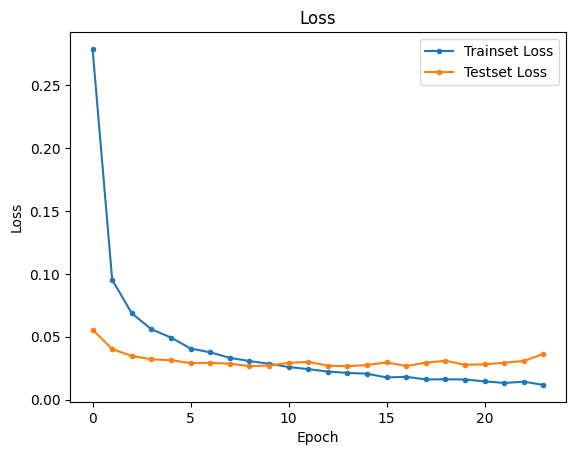

In [18]:
# 시각화 문제
# history를 이용해서 validation loss와 loss를 시각화하시오

import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'],marker='.', label='Trainset Loss')
plt.plot(history.history['val_loss'],marker='.', label='Testset Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
len(history.model.layers)

8

In [23]:
# model의 layer 별로 config를 출력해보시오 
for layer in history.model.layers:
  print(layer.get_config())
  print(layer.get_weights())
# model의 layer 별로 가중치를 출력해보시오 

{'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 28, 28, 1), 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[[ 0.32009724,  0.11564244, -0.35305113,  0.06611026,
           0.12547293, -0.0039196 ,  0.23346043, -0.12618358,
           0.11245633,  0.20690447,  0.22886983, -0.40111184,
          -0.21121772,  0.13651207,  0.0956431 ,  0.2976036 ,
           0.13629419, -0.02226943,  0.05682331, -0.21848652,
           0.11699409, -0.16924697, -0.29013178,  0.07405186,
          -0.0748065 ,  0.1289791 ,  0.24954006, -0.03388887,
  

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1179776   
                                                        

In [13]:
def baseline_model(optimizer='Adam',learning_rate=0.001):  
  model=Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),input_shape=(28,28,1),activation='relu'))
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation='softmax'))
  if optimizer == 'Adam':
    optimizer=tf.keras.optimizers.Adam(learning_rate)
  elif optimizer=='RMSprop':
    optimizer=tf.keras.optimizers.RMSprop(learning_rate)
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,metrics=['accuracy'])
  return model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
model = KerasClassifier(build_fn=baseline_model,verbose=1)
optimizer=['RMSprop','Adam']
learning_rate=[1.0,0.1,0.01,0.001,0.0001]
parameters=dict(optimizer=optimizer,learning_rate=learning_rate)

<ipython-input-13-dc6a90277fe2>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=baseline_model,verbose=1)


In [ ]:
# 수업내용
clf=GridSearchCV(estimator=model,param_grid=parameters,cv=5)
result=clf.fit(X_train,Y_train,epochs=30,batch_size=200)
print('Best: %f using %s' %(result.best_score_,
                            result.best_params_))

In [14]:
# 그리드 탐색 수행
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3)
grid_result = grid.fit(x_train, y_train)  # x_train, y_train은 데이터셋에 맞게 적절히 대체해야 합니다.

# 결과 출력
print("Best Score: ", grid_result.best_score_)
print("Best Params: ", grid_result.best_params_)

1875/1875 [==============================] - 9s 4ms/step - loss: 0.1911 - accuracy: 0.9415
Best Score:  0.9807999928792318
Best Params:  {'learning_rate': 0.001, 'optimizer': 'Adam'}


In [ ]:
# 어제 적용했던
# ModelCheckpoint, EarlyStopping 적용해보기

model = KerasClassifier(build_fn=baseline_model,verbose=1,
                        callbacks=[early_stopping_callback,checkpointer])
optimizer=['RMSprop','Adam']
learning_rate=[1.0,0.1,0.01]
parameters=dict(optimizer=optimizer,learning_rate=learning_rate)

clf=GridSearchCV(estimator=model,param_grid=parameters,cv=5)
result=clf.fit(X_train,Y_train,epochs=30,batch_size=200)

In [ ]:
def seq(optimizer, lr):
  model=Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),input_shape=(28,28,1),activation='relu'))
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer(lr=lr),
                metrics=['accuracy'])
  return model
early_stopping_callback= EarlyStopping(monitor='val_loss',patience=10)
from tensorflow.keras import optimizers
gridcv=GridSearchCV(
    KerasClassifier(build_fn=seq,epochs=30,batch_size=200),
    {'optimizer':[optimizers.Adam,optimizers.SGD,optimizers.RMSprop,
                  optimizers.Nadam,optimizers.Adamax],
     'lr':[.5,.1,.01,.001,.00001],
     'validation_data':[(X_test,Y_test)],
     'callbacks':[[early_stopping_callback]]},n_jobs=-1,verbose=10
)
gridcv.fit(X_train,Y_train,epochs=30,batch_size=200)

# ImageDataGenerator 를 이용한 이미지 증강

11490434/11490434 [==============================] - 2s 0us/step


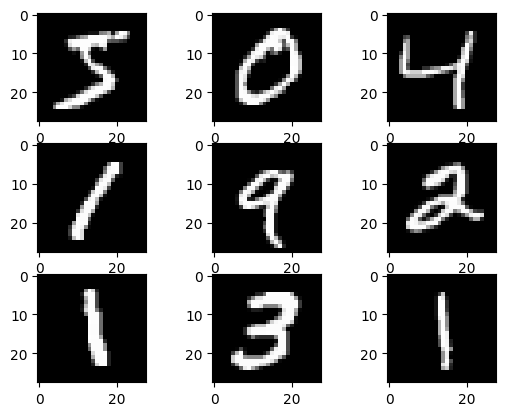

In [1]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
(X_train,y_train),(X_test,y_test)=mnist.load_data()
for i in range(0,9):
  pyplot.subplot(330+1+i)
  pyplot.imshow(X_train[i],cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [10]:
X_train=X_train.reshape(X_train.shape[0],28,28,1)
X_test=X_test.reshape(X_test.shape[0],28,28,1)
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
# Z 점수로 정규: 
# datagen=ImageDataGenerator(zca_whitening=True)
datagen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
datagen=ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2)
datagen=ImageDataGenerator(rotation_range=90)
test_datagen=ImageDataGenerator(rescale=1./255)

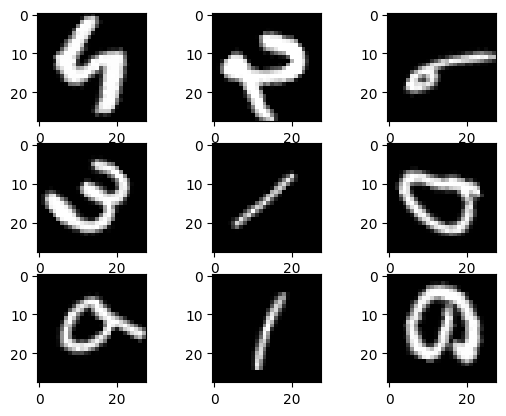

In [11]:
datagen.fit(X_train)
for X_batch,y_batch in datagen.flow(X_train,y_train,batch_size=9,save_to_dir='images',save_prefix='aug',save_format='png'):
  for i in range(0,9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(X_batch[i].reshape(28,28),cmap=pyplot.get_cmap('gray'))
  pyplot.show()
  break

In [14]:
import tensorflow_datasets as tfds

In [15]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 'conll2003',
 'controlled_noisy_web_labels'

In [16]:
import tensorflow as tf
ds=tfds.load('mnist',split='train',shuffle_files=True)
assert isinstance(ds,tf.data.Dataset)
print(ds)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [17]:
ds,info=tfds.load('mnist',split='train',shuffle_files=True,with_info=True)

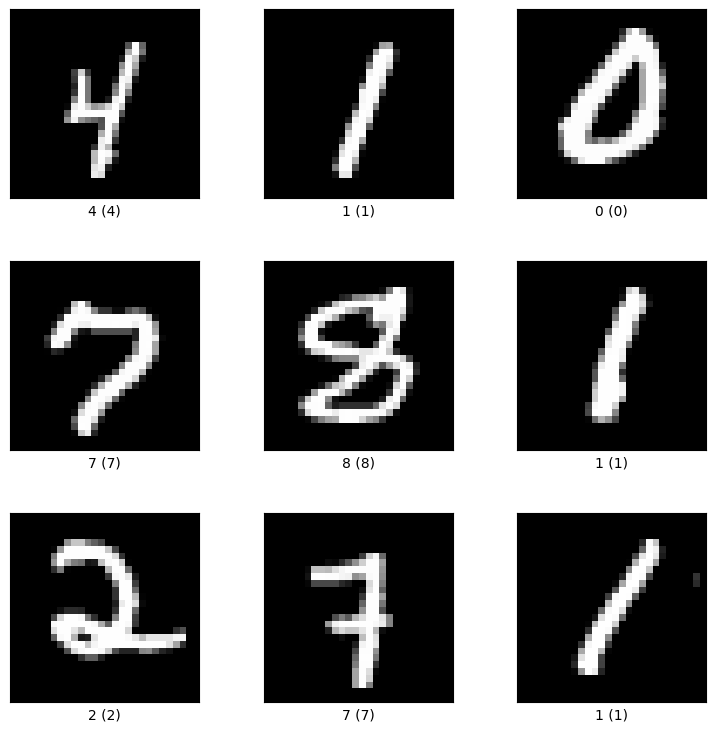

In [18]:
tfds.as_dataframe(ds.take(4),info)
fig=tfds.show_examples(ds,info)

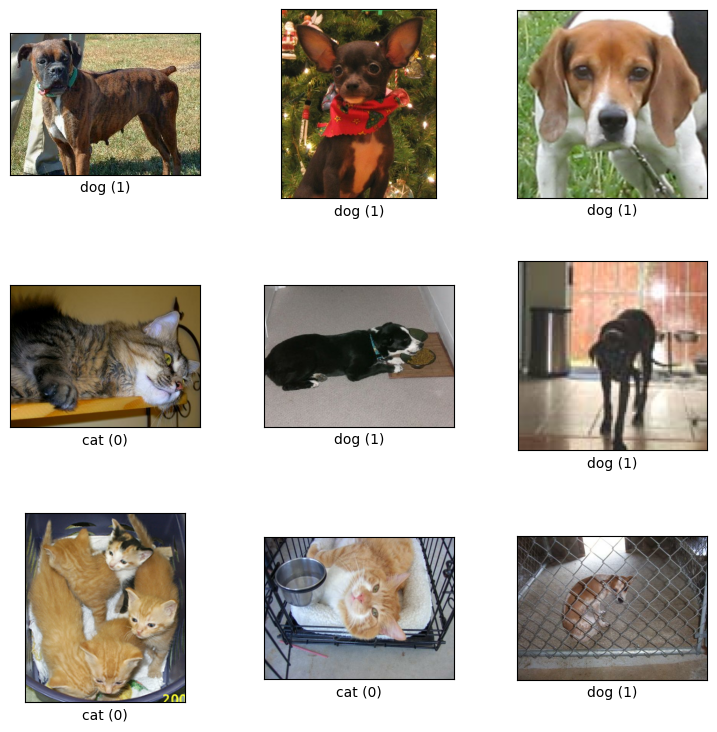

In [22]:
ds,info=tfds.load('CatsVsDogs',split='train',with_info=True)
fig=tfds.show_examples(ds,info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZLRPUQ/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZLRPUQ/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


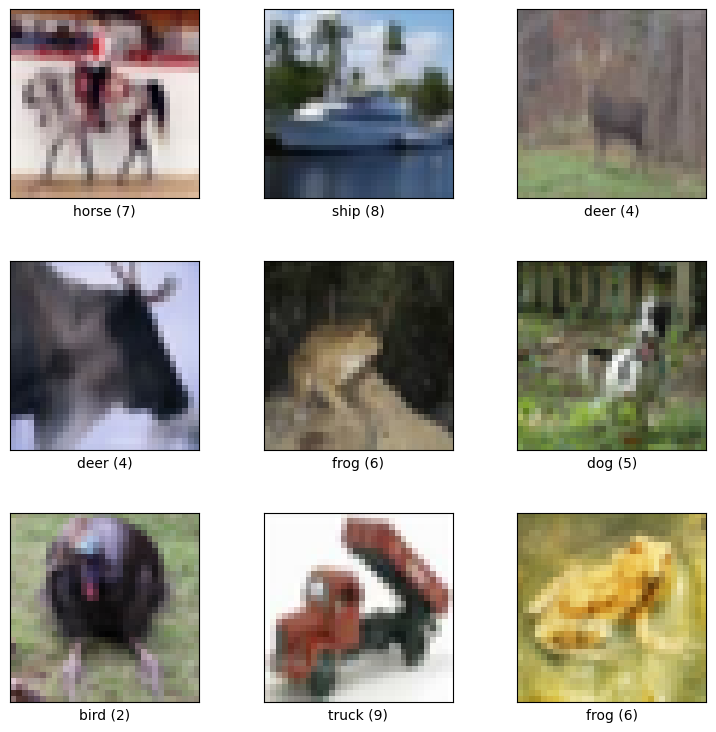

In [23]:
ds,info=tfds.load('cifar10',split='train',with_info=True)
fig=tfds.show_examples(ds,info)

In [134]:
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import random
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [135]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import SGD

In [136]:
with ZipFile('/content/drive/MyDrive/daejeon_1/DataSet/dogs_vs_cats-20230601T053814Z-001.zip') as zip:
  zip.extractall()
  print('done')

done


In [137]:
with ZipFile('/content/dogs_vs_cats/test.zip') as zip:
  zip.extractall()
  print('done')

done


In [138]:
with ZipFile('/content/dogs_vs_cats/train.zip') as zip:
  zip.extractall()
  print('done')

done


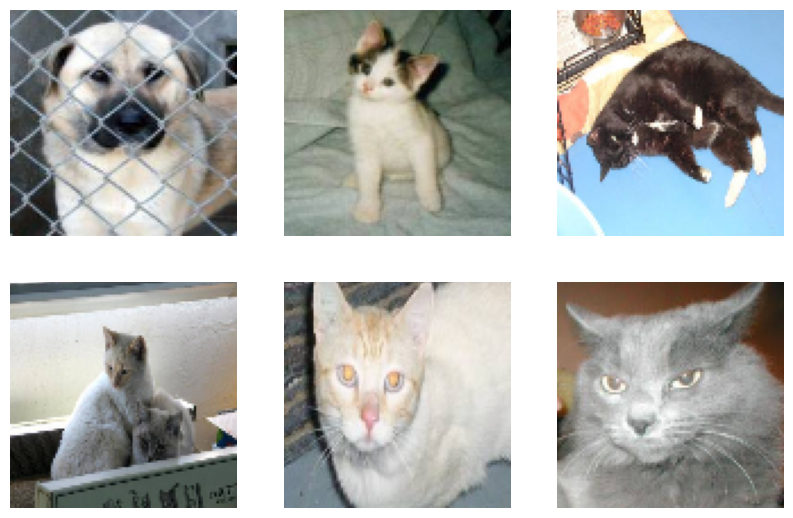

In [139]:
import os 
PATH='/content/train'
filename=os.listdir(PATH) # 파일 이름 리스팅
IMG_SIZE=100

plt.figure(figsize=(10,10))
for i in range(1,7):
  img_array=cv2.imread(os.path.join(PATH,filename[i]))
  # 비대칭 (정방) => 이미지 왜곡
  resize_image=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  plt.subplot(3,3,i)
  # opencv: 이미지를 읽을때 BGR
  # computer RGB
  image=cv2.cvtColor(resize_image,cv2.COLOR_BGR2RGB)
  plt.axis('off')
  plt.imshow(image)

In [140]:
training_data=[]
x_train=[]
y_train=[]
for files in tqdm(os.listdir(PATH)): # progress bar 출력
  try:
    if files.find('cat')==-1: # 못찾으면 -1
      category=0 # dog
    else:
      category=1 # cat
    # 흑백이미지로 로딩
    img_array=cv2.imread(os.path.join(PATH,files),cv2.IMREAD_GRAYSCALE)
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    training_data.append([new_array,category])
    x_train.append([new_array]) # 독립변수
    y_train.append([category])  # 종속변수
  except Exception as e:
    pass

100%|██████████| 25000/25000 [00:24<00:00, 1031.45it/s]


In [141]:
# training_data = []
# x_train = []
# y_train = []
# for files in tqdm(os.listdir(PATH)): # progress bar 출력
#   try:
#     if files.find('cat') == -1: # 못찾으면
#       category = 0 # dog
#     else:
#       category = 1 # cat
#     # 흑백이미지로 로딩
#     img_array = cv2.imread(os.path.join(PATH, files), cv2.IMREAD_GRAYSCALE)
#     new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#     training_data.append([new_array, category])
#     x_train.append([new_array]) # 독립변수
#     y_train.append([new_array]) # 종속변수
#   except Exception as e:
#     pass

In [142]:
# training_data = []
# x_train = []
# y_train = []
# for files in tqdm(os.listdir(PATH)): # progress bar 출력
#   try:
#     if files.find('cat') == -1: # 못찾으면
#       category = 0 # dog
#     else:
#       category = 1 # cat
#     # 흑백이미지로 로딩
#     img_array = cv2.imread(os.path.join(PATH, files), cv2.IMREAD_GRAYSCALE)
#     new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#     training_data.append([new_array, category])
#     x_train.append([new_array]) # 독립변수
#     y_train.append([category]) # 종속변수
#   except Exception as e:
#     pass

In [143]:
# training_data = []
# x_train = []
# y_train = []

# for files in tqdm(os.listdir(PATH)):  # tqdm : progress bar 출력
#     try:
#         if files.find('cat') == -1:  # 못 찾으면 -1
#             category = 0    # 0 = dog
#         else:
#             category = 1    # 1 = cat
#             # 흑백이미지로 로딩
#         img_array = cv2.imread(os.path.join(PATH, files), cv2.IMREAD_GRAYSCALE)
#         new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#         training_data.append([new_array, category])
#         x_train.append([new_array]) # 독립
#         y_train.append([category])  # 종속
#     except Exception as e:
#         pass

In [144]:
x_train=np.array(x_train)

In [145]:
y_train=np.array(y_train)

In [146]:
x_train.shape

(25000, 1, 100, 100)

In [147]:
x_train=x_train.reshape(25000,100,100,1)

In [148]:
x_train.shape

(25000, 100, 100, 1)

In [149]:
y_train.shape

(25000, 1)

In [150]:
testing_data=[]
PATH='/content/test'

for files in tqdm(os.listdir(PATH)):
  try:
    img_array=cv2.imread(os.path.join(PATH,files),cv2.IMREAD_GRAYSCALE)
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    testing_data.append([new_array])
  except Exception as e:
    pass

100%|██████████| 12500/12500 [00:12<00:00, 996.34it/s] 


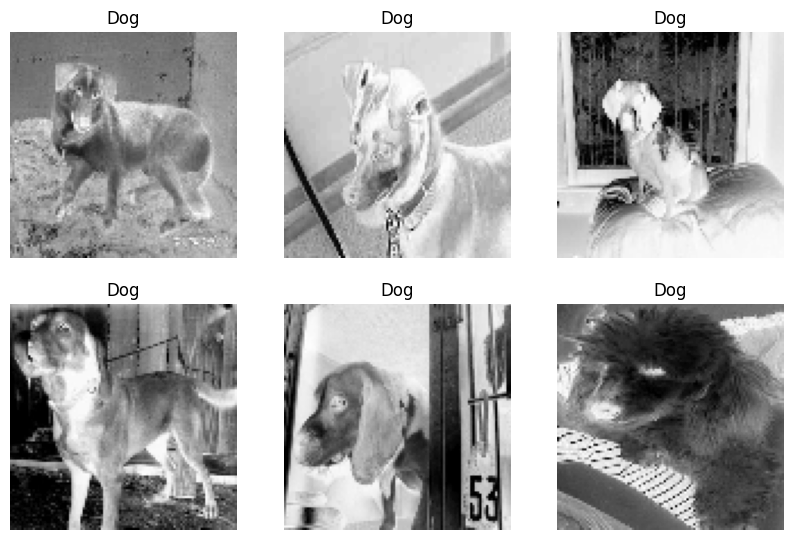

In [151]:
plt.figure(figsize=(10,10))
for i in range(1,7):
  plt.subplot(3,3,i)
  plt.axis('off')
  if training_data[10+i][1]==0:
    plt.title('Dog')
  else:
    plt.title('Cat')
  plt.imshow(training_data[10+i][0],cmap='gray_r')

In [152]:
random.seed(45)
random.shuffle(training_data)
X=[]
y=[]
for features,labels in training_data:
  X.append(features.reshape(100,100,1))
  y.append(labels)

In [153]:
X_train,X_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.3,random_state=51)
X_train.shape

(17500, 100, 100, 1)

In [154]:
X_train=X_train/255.0
X_test=X_test/255.0

In [155]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [156]:
model=Sequential()
# CNN(convolution neural network)
model.add(Conv2D(32,kernel_size=(5,5),activation='relu',input_shape=(100,100,1)))
# 가중치 5x5x32+32
# 96x96x32
model.add(Conv2D(64,kernel_size=(5,5),activation='relu'))
# 5x5x64+64
# 92x92x64
model.add(MaxPooling2D(pool_size=(4,4)))
# 23x23x64
model.add(Flatten())
# FFNN(feed forward neural network)
model.add(Dense(512,activation='relu'))
# 가중치 33856 * 512
# 이미지 배치사이즈 *512 
model.add(Dense(2,activation='softmax'))
# 가중치 
model.compile(loss='categorical_crossentropy',optimizer=SGD(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        832       
                                                                 
 conv2d_11 (Conv2D)          (None, 92, 92, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 33856)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               17334784  
                                                                 
 dense_9 (Dense)             (None, 2)                 1026      
                                                      

In [157]:
batch_size=32
epochs=10

history=model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,
                  verbose=1,validation_data=(X_test,y_test))

score=model.evaluate(X_test,y_test,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[0])

Epoch 1/10
547/547 [==============================] - 28s 31ms/step - loss: 0.6881 - accuracy: 0.5514 - val_loss: 0.6827 - val_accuracy: 0.6005
Epoch 2/10
547/547 [==============================] - 15s 27ms/step - loss: 0.6809 - accuracy: 0.5827 - val_loss: 0.6752 - val_accuracy: 0.6009
Epoch 3/10
547/547 [==============================] - 14s 26ms/step - loss: 0.6741 - accuracy: 0.5929 - val_loss: 0.6681 - val_accuracy: 0.6161
Epoch 4/10
547/547 [==============================] - 14s 26ms/step - loss: 0.6665 - accuracy: 0.6097 - val_loss: 0.6615 - val_accuracy: 0.6151
Epoch 5/10
547/547 [==============================] - 14s 26ms/step - loss: 0.6598 - accuracy: 0.6149 - val_loss: 0.6551 - val_accuracy: 0.6261
Epoch 6/10
547/547 [==============================] - 15s 27ms/step - loss: 0.6530 - accuracy: 0.6182 - val_loss: 0.6558 - val_accuracy: 0.6043
Epoch 7/10
547/547 [==============================] - 14s 26ms/step - loss: 0.6473 - accuracy: 0.6257 - val_loss: 0.6427 - val_accuracy:

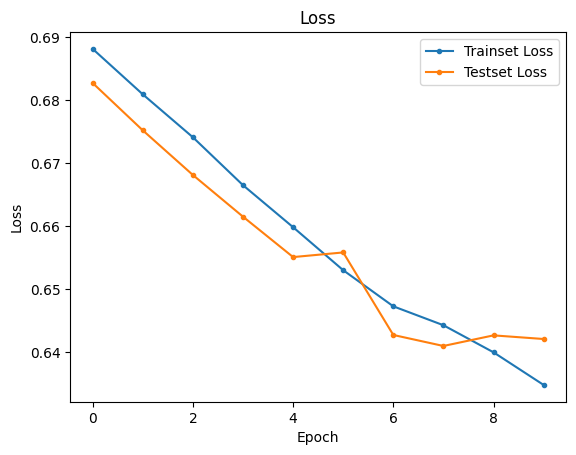

In [158]:
# 문제
# history : val_loss, loss 시각화

import matplotlib.pyplot as plt
# 손실 그래프
plt.plot(history.history['loss'],marker='.', label='Trainset Loss')
plt.plot(history.history['val_loss'],marker='.', label='Testset Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



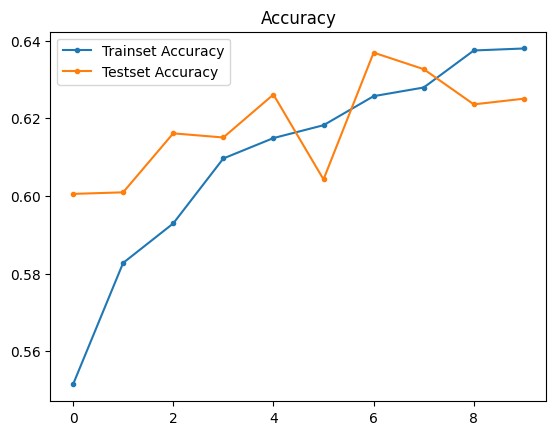

In [159]:
# 문제
# val_cccuracy, accuracy 시각화
plt.plot(history.history['accuracy'],marker='.',label='Trainset Accuracy')
plt.plot(history.history['val_accuracy'],marker='.',label='Testset Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [161]:
# 문제
# 예측을 하고 실제데이터와 평가해보시오
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test, axis=1)

# 평가
accuracy = np.mean(predicted_labels == actual_labels)
print("Accuracy:", accuracy)


235/235 [==============================] - 2s 7ms/step
Accuracy: 0.6250666666666667
